In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc
import operator

In [2]:
sns.set_context('talk')

In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
import warnings
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')

# Read the data

In [5]:
dfXtrain = pd.read_csv('preprocessed_csv/train_4.csv', index_col='id', sep=';')
dfXtest = pd.read_csv('preprocessed_csv/test_4.csv', index_col='id', sep=';')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_4.csv', header=None, names=['ID', 'COTIS'], sep=';')

In [6]:
dfYtrain = dfYtrain.set_index('ID')

# Preprocessing

Вынесем var14, department и subreg.

In [7]:
dropped_col_names = ['department', 'subreg', 'ext_dep'] 

def drop_cols(df):
    return df.drop(dropped_col_names, axis=1), df[dropped_col_names]

In [8]:
train, dropped_train = drop_cols(dfXtrain)
test, dropped_test = drop_cols(dfXtest)

Добавим инфу о величине города из subreg'a

In [9]:
def add_big_city_cols(df, dropped_df):
    df['big'] = np.where(dropped_df['subreg'] % 100 == 0, 1, 0)
    df['average'] = np.where(dropped_df['subreg'] % 10 == 0, 1, 0)
    df['average'] = df['average'] - df['big']
    df['small'] = 1 - df['big'] - df['average']
    return df

In [10]:
train = add_big_city_cols(train, dropped_train)
test = add_big_city_cols(test, dropped_test)

Декодируем оставшиеся категориальные признаки

In [11]:
numerical = list(train.select_dtypes(include=[np.number]).columns)
numerical

['puis_fiscale',
 'anc_veh',
 'kmage_annuel',
 'crm',
 'var1',
 'var2',
 'var3',
 'var4',
 'var5',
 'var7',
 'var9',
 'var10',
 'var11',
 'var13',
 'var15',
 'var16',
 'var17',
 'var18',
 'var19',
 'var20',
 'var21',
 'var22',
 'age',
 'big',
 'average',
 'small']

In [12]:
categorical = list(train.select_dtypes(exclude=[np.number]).columns)
categorical

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [13]:
list(test.select_dtypes(exclude=[np.number]).columns)

['marque', 'energie_veh', 'profession', 'var6', 'var8', 'var14']

In [14]:
for col in categorical:
    print(col, train[col].nunique(), test[col].nunique())

marque 154 73
energie_veh 5 5
profession 17 17
var6 5 5
var8 23 19
var14 8 1


energie_veh и var6 с помощью get_dummies

In [15]:
train.energie_veh.unique()

array(['gpl', 'hybride essence', 'electricite', 'gazole', 'essence', nan], dtype=object)

In [16]:
test.energie_veh.unique()

array(['essence', 'gazole', 'gpl', 'hybride essence', nan, 'electricite'], dtype=object)

In [17]:
small_cat = ['energie_veh', 'var6']

In [18]:
train = pd.get_dummies(train, columns=small_cat)
test = pd.get_dummies(test, columns=small_cat)

Теперь посмотрим на остальные

In [19]:
len(set(train.profession.values) - set(test.profession.values))

0

In [20]:
len(set(train.var8.values) - set(test.var8.values))

4

In [21]:
len(set(test.var8.values) - set(train.var8.values))

0

In [22]:
len(set(train.marque.values) - set(test.marque.values))

83

In [23]:
len(set(test.marque.values) - set(train.marque.values))

2

In [24]:
set(test.marque.values) - set(train.marque.values)

{'GEELY', 'SOVAM'}

In [25]:
test[test.marque == 'GEELY']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
305916,GEELY,5,0,7421,50,technicien,6.0,3,272,0,1,1.0,M1,94,150,0,4,N,2,4.0,1,20,0,1,1,4,25.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
test[test.marque == 'SOVAM']

,marque,puis_fiscale,anc_veh,kmage_annuel,crm,profession,var1,var2,var3,var4,var5,var7,var8,var9,var10,var11,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,age,big,average,small,energie_veh_electricite,energie_veh_essence,energie_veh_gazole,energie_veh_gpl,energie_veh_hybride essence,var6_A,var6_B,var6_C,var6_D,var6_N
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
318867,SOVAM,9,19,17000,50,"agent, employe",28.0,5,372,7,1,20.0,K2,0,0,19,5,N,3,1.0,1,19,0,0,1,0,47.0,0,0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


profession и var8 тоже в dummy

In [27]:
middle_cat = ['profession', 'var8', 'marque', 'var14']

In [28]:
bigX = pd.concat([train, test])

In [29]:
bigX.shape

(330000, 40)

In [30]:
bigX = pd.get_dummies(bigX, columns=middle_cat)

In [31]:
bigX.shape

(330000, 240)

Расположим столбцы в нужном порядке, добавим константный столбец

In [32]:
bigX.crm /= 100

In [33]:
first_col_list = ['crm', 'puis_fiscale']
col_list = first_col_list + sorted(list(set(bigX.columns) - set(first_col_list)))

In [34]:
bigX = bigX[col_list]

Разберёмся с нумериками

In [35]:
numerical = set(numerical)
numerical -= set(['big', 'average', 'small'])

In [36]:
for col in numerical:
    treshold = 10
    if bigX[col].nunique() <= treshold:
        print(col, bigX[col].nunique())

var15 10
var3 2
var13 4
var17 6
var2 6
var5 2
var21 2
var4 10
var16 6
var20 2


Эти (что выше) можно ohe

In [37]:
for col in numerical:
    treshold = 10
    if bigX[col].nunique() > treshold:
        print(col, bigX[col].nunique())

var18 46
age 69
anc_veh 44
var22 25
crm 150
var7 18
var1 70
var9 335
kmage_annuel 1263
puis_fiscale 51
var19 29
var11 44
var10 213


* crm выкидывается
* var1 порог 3
* age порог 22

In [38]:
intercept = 50
base = 400

In [39]:
target = (dfYtrain.COTIS - intercept)/ train.crm * 100 / base

In [40]:
target.describe()

count    300000.000000
mean          1.022082
std           0.296673
min           0.223900
25%           0.805200
50%           1.000818
75%           1.212143
max           2.815150
dtype: float64

50 и 400 хорошо ложатся

In [41]:
bigX.fillna(-9999, inplace=True)

In [136]:
y_train = np.array(dfYtrain)
train = bigX.loc[train.index]
x_train = np.array(train)
test = bigX.loc[test.index]
x_test = np.array(test)

In [137]:
x_train.shape

(300000, 240)

In [138]:
x_test.shape

(30000, 240)

# Save routines

In [45]:
dfYtest = pd.DataFrame({'ID': dfXtest.index, 'COTIS': np.zeros(test.shape[0])})
dfYtest = dfYtest[['ID', 'COTIS']]
dfYtest.head()

,ID,COTIS
0,300001,0.0
1,300002,0.0
2,300003,0.0
3,300004,0.0
4,300005,0.0


In [46]:
def save_to_file(y, file_name):
    dfYtest['COTIS'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False, sep=';')

In [47]:
model_name = 'divided'
dfYtest_stacking = pd.DataFrame({'ID': dfXtrain.index, model_name: np.zeros(train.shape[0])})
dfYtest_stacking = dfYtest_stacking[['ID', model_name]]
dfYtest_stacking.head()

,ID,divided
0,1,0.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [48]:
def save_to_file_stacking(y, file_name):
    dfYtest_stacking[model_name] = y
    dfYtest_stacking.to_csv('stacking/{}'.format(file_name), index=False, sep=';')

# Train model

In [49]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(np.sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)
    
    params = grid_searcher.param_grid
    
    plt.figure(figsize=(10, 6))
    plt.plot(params[param_name], means)
    plt.fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    plt.xlabel(param_name)
    plt.ylabel('MAPE')

In [50]:
def mape(y_true, y_pred): 
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
def mape_scorer(est, X, y):
    gc.collect()
    return mape(y, est.predict(X))

In [52]:
class MyGS():
    class Element():
        def __init__(self):
            self.cv_validation_scores = []
        
        
        def add(self, score):
            self.cv_validation_scores.append(score)
    
    
    def __init__(self, param_grid, name, n_folds):
        self.param_grid = {name: param_grid}
        self.grid_scores_ = [MyGS.Element() for item in param_grid]
        self.est = None
        
    
    def add(self, score, param_num):
        self.grid_scores_[param_num].add(score)
        

In [53]:
intercept = 50
base = 400

def scorer(y_true, y_pred, crm):
    y_true = inv_func(y_true, crm)
    y_pred = inv_func(y_pred, crm)
    return mape(y_true, y_pred)

In [54]:
def func(y, crm):
    return (y - intercept) / crm / base

In [55]:
def inv_func(y, crm):
    return y * crm * base + intercept

In [139]:
validation_index = (dropped_train.ext_dep == 10) | (dropped_train.ext_dep > 900)
train_index = ~validation_index

In [140]:
subtrain, validation = train[train_index], train[validation_index]
x_subtrain = np.array(subtrain)
x_validation = np.array(validation)

ysubtrain, yvalidation = dfYtrain[train_index], dfYtrain[validation_index]
y_subtrain = np.array(ysubtrain).flatten()
y_validation = np.array(yvalidation).flatten()

In [58]:
validation.shape

(33155, 240)

In [59]:
from sklearn.tree import LinearDecisionTreeRegressor as LDTR

In [60]:
from sklearn.tree import DecisionTreeRegressor

In [61]:
from sklearn.ensemble import ExtraTreesRegressor

In [66]:
from sklearn.model_selection import ShuffleSplit

In [94]:
%%time

n_splits = 1000
rs = ShuffleSplit(n_splits=n_splits, test_size=None, train_size=1 / 1000, random_state=42)
estimators = []
y_pred = 0

for train_index, test_index in rs.split(x_subtrain):
    estimators.append(LDTR(n_coefficients=1, n_first_dropped=1, const_term=True,
                           max_depth=5, random_state=42).fit(
                        x_subtrain[train_index], y_subtrain[train_index]))
    y_pred += estimators[-1].predict(x_validation)
    
y_pred /= n_splits

CPU times: user 33.7 s, sys: 0 ns, total: 33.7 s
Wall time: 33.7 s


In [95]:
mape(y_validation, y_pred)

-12.691388494241659

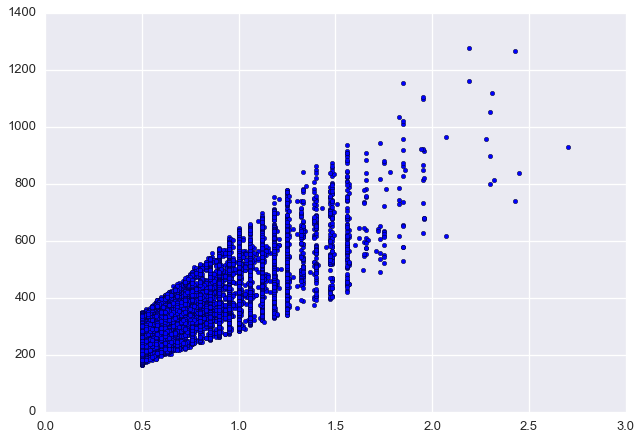

In [96]:
plt.scatter(x_validation[:, 0], y_pred)

In [408]:
%%time

intercept = 50
sample_weight_subtrain = np.power(y_subtrain, -1)

n_estimators = 100
estimators = []
weights = []
diff = y_subtrain - 0
estimators.append(LDTR(n_coefficients=1, n_first_dropped=1, const_term=False,
                       max_depth=25, random_state=42, min_samples_leaf=50).fit(
                    x_subtrain, diff - intercept, sample_weight=sample_weight_subtrain))
diff -= estimators[-1].predict(x_subtrain) + intercept
weights.append(1)

rs = ShuffleSplit(n_splits=n_estimators, test_size=1 / 100, train_size=1 / 1000, random_state=42)

for random_state, (train_index, test_index) in enumerate(rs.split(x_subtrain)):
    grad = diff
    estimators.append(LDTR(n_coefficients=2, n_first_dropped=0, const_term=False,
                           max_depth=1, random_state=random_state, min_samples_leaf=5, splitter='random').fit(
                        x_subtrain, grad))
    grad = estimators[-1].predict(x_subtrain)
    good_error = 100000
    good_weight = 0
    for coef in [0.001, 0.01, 0.1, 1, 10]:
        error = np.mean(np.abs(diff - grad * coef) / y_subtrain)
        if error < good_error:
            good_weight = coef
            good_error = error
    if good_weight > 0:
        weights.append(good_weight)
        diff -= good_weight * estimators[-1].predict(x_subtrain)

CPU times: user 2min 7s, sys: 13.9 s, total: 2min 21s
Wall time: 2min 21s


In [409]:
y_pred = sum(weight * est.predict(x_validation) for weight, est in zip(weights, estimators)) + intercept

In [410]:
mape(y_validation, y_pred)

-9.7748333621895203

In [411]:
weights

[1,
 0.1,
 0.1,
 0.1,
 0.1,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001]

In [126]:
%%time
est = ExtraTreesRegressor(n_estimators=10, max_features=None, 
                          max_depth=None, n_jobs=-1, random_state=42).fit(
    X=x_subtrain, y=func(y_subtrain, x_subtrain[:, 0]), sample_weight=None)

CPU times: user 3min 9s, sys: 1.4 s, total: 3min 10s
Wall time: 55.9 s


In [127]:
y_pred = inv_func(est.predict(x_validation), x_validation[:, 0])
mape(y_validation, y_pred)

-9.9668135794500436

In [128]:
gc.collect()

127

In [130]:
sample_weight_subtrain = np.power(y_subtrain, -1)

In [131]:
%%time
est = DecisionTreeRegressor(max_features=None, 
                          max_depth=None, random_state=42).fit(
    X=x_subtrain, y=func(y_subtrain, x_subtrain[:, 0]), sample_weight=sample_weight_subtrain)

CPU times: user 18.6 s, sys: 172 ms, total: 18.8 s
Wall time: 18.8 s


In [132]:
y_pred = inv_func(est.predict(x_validation), x_validation[:, 0])
mape(y_validation, y_pred)

-13.18587197783933

In [133]:
gc.collect()

160

In [134]:
import xgboost as xgb

/home/alexey/.environments/ml/lib/python3.4/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [167]:
def grid_search(x_train, y_train, x_validation, y_validation, scorer, weights=None):
    param =   {'base_score':0.5, 'colsample_bylevel':1, 'colsample_bytree':1, 'gamma':0,
               'eta':0.15, 'max_delta_step':0, 'max_depth':15,
               'min_child_weight':20, 'nthread':-1,
               'objective':'reg:linear', 'alpha':0, 'lambda':1,
               'scale_pos_weight':1, 'seed':56, 'silent':True, 'subsample':1}

    diff_num_round_list = [4 for i in range(5)]
    diff_num_round_list[0] = 60
    num_round_list = np.cumsum(diff_num_round_list)
    n_folds = 1

    mygs = MyGS(num_round_list, 'num_round', n_folds=n_folds)

    #label_kfold = LabelKFold(np.array(dropped_train['department']), n_folds=n_folds)
    
    
    dtrain = xgb.DMatrix(x_train, 
                         label=y_train, 
                         missing=-9999,
                         weight=weights) 
    dvalidation = xgb.DMatrix(x_validation, missing=-9999)
    param['base_score'] = np.mean(y_train)
    bst = None
    for index, diff_num_round in enumerate(diff_num_round_list):
        bst = xgb.train(param, dtrain, diff_num_round, xgb_model=bst)
        y_pred = bst.predict(dvalidation)
        score = scorer(y_validation, y_pred, x_validation[:, 0])
        mygs.add(score, index)
    mygs.est = bst
    gc.collect()
    return mygs

In [168]:
%%time
mygs = grid_search(x_subtrain, func(y_subtrain, x_subtrain[:, 0]), 
                   x_validation, func(y_validation, x_validation[:, 0]), 
                   scorer, None)

CPU times: user 15min 44s, sys: 1.03 s, total: 15min 45s
Wall time: 15min 45s


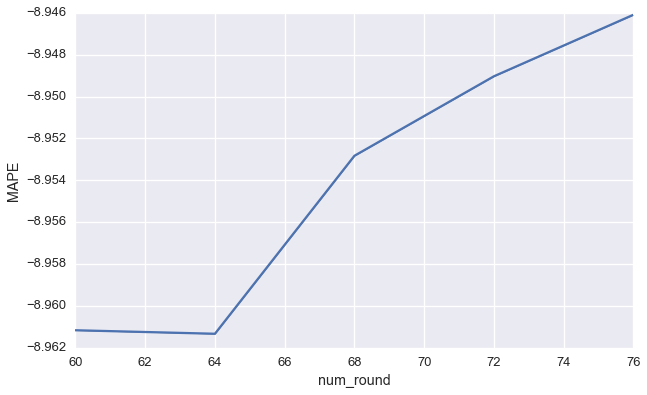

In [169]:
plot_quality(mygs, 'num_round')

min_child_weight = 5

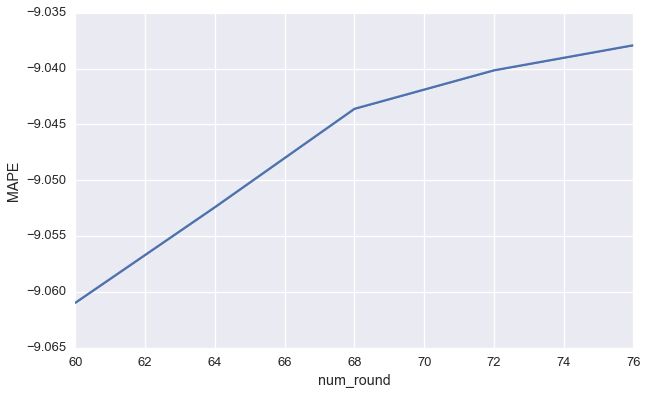

In [166]:
plot_quality(mygs, 'num_round')

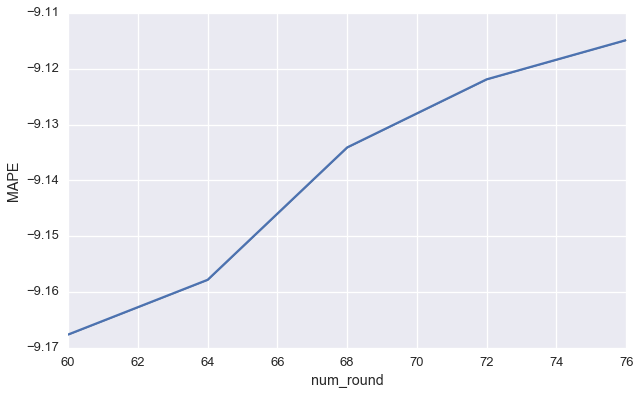

In [162]:
plot_quality(mygs, 'num_round')

In [163]:
gc.collect()

4401

In [140]:
dvalidation = xgb.DMatrix(x_validation, missing=-9999)

In [142]:
y_pred = inv_func(mygs.est.predict(dvalidation), x_validation[:, 0])

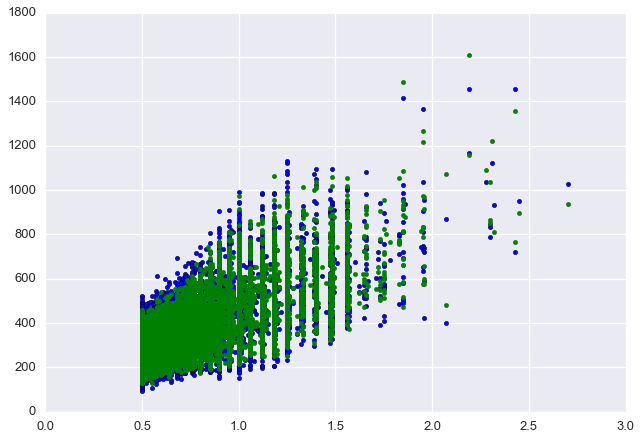

In [146]:
plt.scatter(x_validation[:, 0], y_validation)
plt.scatter(x_validation[:, 0], y_pred, color='g')
plt.show()

# Save

In [144]:
%%time
est = LDTR(max_features=None, max_depth=15, random_state=42,
           n_coefficients=2, n_first_dropped=2, const_term=True, min_samples_leaf=40).fit(
    X=x_train, y=y_train, sample_weight=np.power(y_train.flatten(), -1))

CPU times: user 19 s, sys: 248 ms, total: 19.2 s
Wall time: 19.3 s


In [145]:
y_pred = est.predict(x_test)

In [146]:
save_to_file(y_pred, 'ldtr.csv')